In [ ]:
!pip install textblob nltk vaderSentiment
nltk.download('punkt')

In [2]:
import pandas as pd
import torch
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
import numpy as np

device = 0 if torch.cuda.is_available() else -1
device

-1

In [2]:
filepath = r"combined_df.csv"
df = pd.read_csv(filepath, dtype=str).sort_values(by='Survey ID')
#df
df['Combined Text'] = df['Combined Text'].astype(str)

 Text Blob/
 TextBlob Naive Bayes/
 NLTK VADER

In [11]:
def textblob_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

def textblob_naive_bayes_sentiment(text):
    blob = TextBlob(text, analyzer=NaiveBayesAnalyzer())
    return blob.sentiment.classification

def nltk_vader_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(text)
    return vs['compound']

In [13]:
sampled_df = df.sample(n=1000, random_state=42)
#sampled_df=pd.read_csv('sentiment_analysis_output[WD].csv')
#sampled_df['Combined Text'] = sampled_df['Combined Text'].astype(str)

In [ ]:
sampled_df['TextBlob_Sentiment'] = sampled_df['Combined Text'].apply(textblob_sentiment)

sampled_df['TextBlob_NaiveBayes_Sentiment'] = sampled_df['Combined Text'].apply(textblob_naive_bayes_sentiment)
#25mins for 1000 rows

sampled_df['NLTK_Vader_Sentiment'] = sampled_df['Combined Text'].apply(nltk_vader_sentiment)

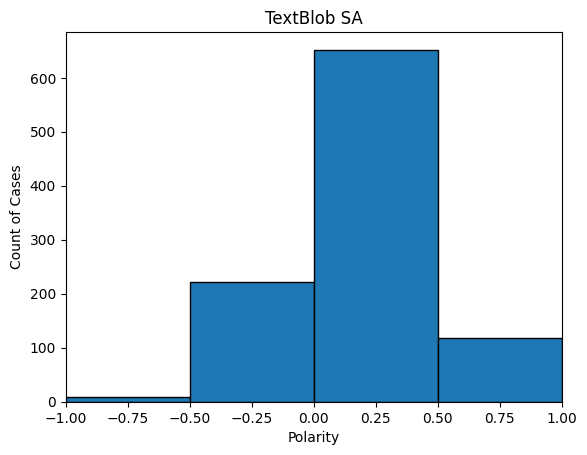

In [24]:
import matplotlib.pyplot as plt

# Define the bins
bins = [-1, -0.5, 0, 0.5, 1]

# Create the histogram
hist, bin_edges = np.histogram(sampled_df['TextBlob_Sentiment'], bins=bins)

# Plot the bar chart
plt.bar(bin_edges[:-1], hist, width=0.5, edgecolor='black', align='edge')

# Set the labels and title
plt.xlabel('Polarity')
plt.ylabel('Count of Cases')
plt.title('TextBlob SA')

# Set the x-axis limits
plt.xlim(-1, 1)

# Show the plot
plt.show()

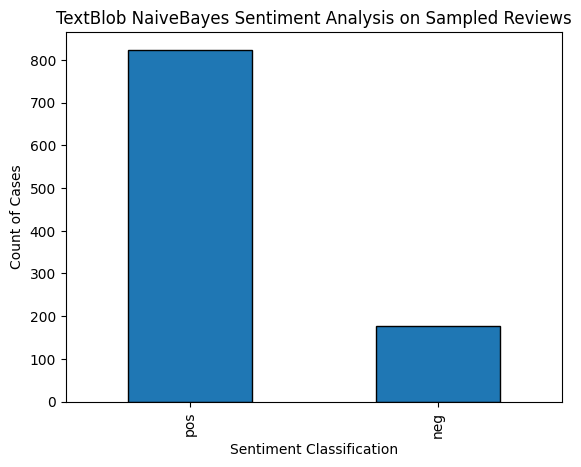

In [11]:
import matplotlib.pyplot as plt

# Count the occurrences of each sentiment classification
sentiment_counts = sampled_df['TextBlob_NaiveBayes_Sentiment'].value_counts()

# Plot the bar chart
sentiment_counts.plot(kind='bar', edgecolor='black')

# Set the labels and title
plt.xlabel('Sentiment Classification')
plt.ylabel('Count of Cases')
plt.title('TextBlob NaiveBayes Sentiment Analysis on Sampled Reviews')

# Show the plot
plt.show()

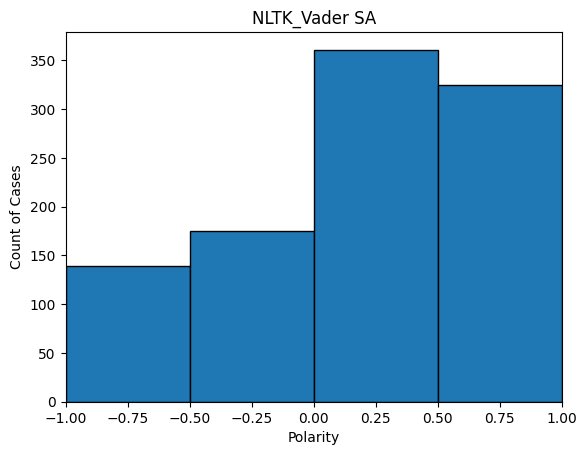

In [7]:
import matplotlib.pyplot as plt

# Define the bins
bins = [-1, -0.5, 0, 0.5, 1]

# Create the histogram
hist, bin_edges = np.histogram(sampled_df['NLTK_Vader_Sentiment'], bins=bins)

# Plot the bar chart
plt.bar(bin_edges[:-1], hist, width=0.5, edgecolor='black', align='edge')

# Set the labels and title
plt.xlabel('Polarity')
plt.ylabel('Count of Cases')
plt.title('NLTK_Vader SA')

# Set the x-axis limits
plt.xlim(-1, 1)

# Show the plot
plt.show()

Post SA Output Representation & Evaluation

In [15]:
sampled_df.to_csv('sentiment_analysis_output[WD].csv', index=False)

In [47]:
###########get df after sentiment analysis
df_sa=pd.read_csv('sentiment_analysis_output[WD].csv')
    
df_sa['Sentiment_Label_TB'] = df_sa['TextBlob_Sentiment'].apply(lambda x: 'Positive' if x >= 0 else 'Negative')
df_sa['Sentiment_Label_TB_NB'] = df_sa['TextBlob_NaiveBayes_Sentiment'].apply(lambda x: 'Positive' if x == 'pos' else 'Negative')
df_sa['Sentiment_Label_VADER'] = df_sa['NLTK_Vader_Sentiment'].apply(lambda x: 'Positive' if x >= 0.05 else ('Negative' if x <= -0.05 else 'Neutral'))


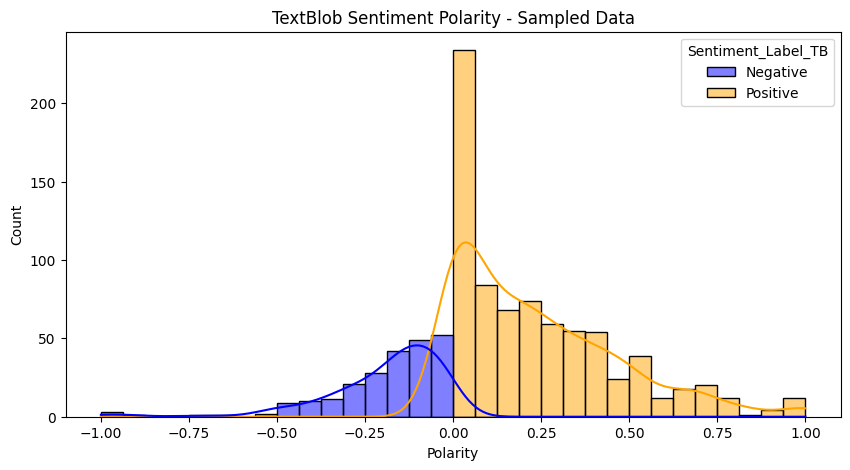

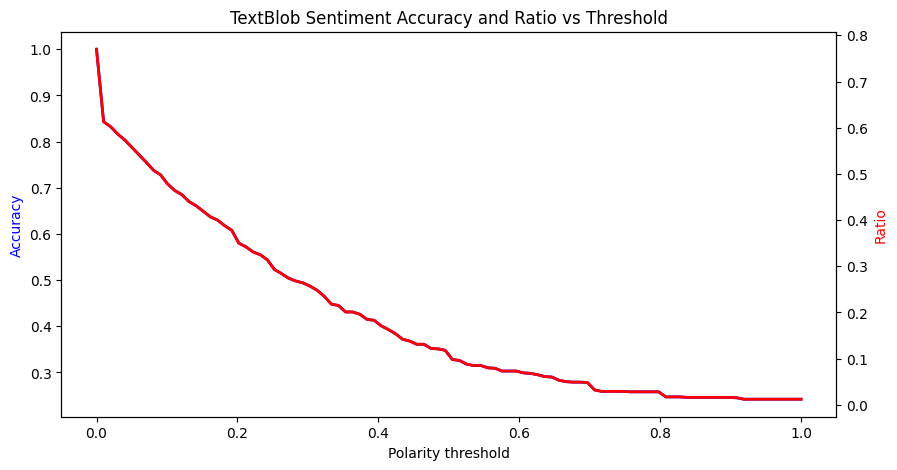

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution
plt.figure(figsize=(10, 5))

# Histogram of sentiment polarity
sns.histplot(data=df_sa, x='TextBlob_Sentiment', hue='Sentiment_Label_TB', kde=True, palette={"Positive": "orange", "Negative": "blue"})

plt.title("TextBlob Sentiment Polarity - Sampled Data")
plt.xlabel("Polarity")
plt.ylabel("Count")
plt.show()


# Generate accuracy and ratio based on thresholds
thresholds = np.linspace(0, 1, 100)
accuracy = []
neg_pos_ratio = []

for threshold in thresholds:
    predicted_pos = df_sa['TextBlob_Sentiment'] >= threshold
    actual_pos = df_sa['Sentiment_Label_TB'] == 'Positive'
    
    acc = (predicted_pos == actual_pos).mean()
    ratio = predicted_pos.mean()
    
    accuracy.append(acc)
    neg_pos_ratio.append(ratio)

# Plot the accuracy and ratio
fig, ax1 = plt.subplots(figsize=(10, 5))

# Accuracy plot
ax1.plot(thresholds, accuracy, 'b-', label='Accuracy (neg/pos)', linewidth=2)
ax1.set_xlabel('Polarity threshold')
ax1.set_ylabel('Accuracy', color='b')

# Share x-axis for ratio
ax2 = ax1.twinx()
ax2.plot(thresholds, neg_pos_ratio, 'r-', label='Ratio (neg/pos vs all)', linewidth=2)
ax2.set_ylabel('Ratio', color='r')

plt.title('TextBlob Sentiment Accuracy and Ratio vs Threshold')
plt.show()


Comparing SA output with True label

In [51]:
def score_to_sentiment(row):
    if not pd.isna(row['LTR']):
        # Use LTR (0-10)
        if row['LTR'] <= 3:
            return 'Negative'
        elif row['LTR'] <= 6:
            return 'Neutral'
        else:
            return 'Positive'
    elif not pd.isna(row['Star Rating']):
        # Use Star_Rating (1-5)
        if row['Star_Rating'] <= 2:
            return 'Negative'
        elif row['Star_Rating'] == 3:
            return 'Neutral'
        else:
            return 'Positive'
    else:
        return 'Unknown'  
    
df_sa['True_Label'] = df_sa.apply(score_to_sentiment, axis=1)


print(df_sa[['LTR', 'Star Rating', 'True_Label']].sample(20))
#print random enties to validate the labels


     LTR  Star Rating True_Label
241   10          NaN   Positive
408   10          5.0   Positive
226    1          NaN   Negative
106    0          NaN   Negative
920   10          5.0   Positive
832    8          NaN   Positive
548   10          5.0   Positive
716   10          5.0   Positive
589   10          NaN   Positive
621    2          NaN   Negative
490    9          NaN   Positive
46     6          NaN    Neutral
454    8          4.0   Positive
161    0          NaN   Negative
114    0          NaN   Negative
872   10          5.0   Positive
750    0          NaN   Negative
21    10          5.0   Positive
197    9          NaN   Positive
932    8          NaN   Positive


In [53]:
def calculate_accuracy(true_labels, predicted_labels):
    return (true_labels == predicted_labels).mean()

textblob_accuracy = calculate_accuracy(df_sa['True_Label'], df_sa['Sentiment_Label_TB'])
textblob_nb_accuracy = calculate_accuracy(df_sa['True_Label'], df_sa['Sentiment_Label_TB_NB'])  
vader_accuracy = calculate_accuracy(df_sa['True_Label'], df_sa['Sentiment_Label_VADER'])  

print(f"TextBlob Accuracy: {textblob_accuracy:.2f}")
print(f"TextBlob Naive Bayes Accuracy: {textblob_nb_accuracy:.2f}")
print(f"VADER Accuracy: {vader_accuracy:.2f}")


TextBlob Accuracy: 0.63
TextBlob Naive Bayes Accuracy: 0.53
VADER Accuracy: 0.60


In [65]:
import tabulate

print(tabulate.tabulate(df_sa[['Combined Text', 'Sentiment_Label_TB', 'Sentiment_Label_TB_NB', 'Sentiment_Label_VADER', 'True_Label','LTR','Star Rating']].sample(10)))

---  ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  --------  --------  --------  --------  --  ---
403  Previously used a universal product but was a false economy. This arrived quickly and the printer recognised it as a Hp product & seemed to like that.                                                                                                                                                     Negative  Positive  Positive  Positive   8    4
986  Outstanding pro0duct                                                                                                                                                                                                                                                                               

  True_Label  TextBlob  TextBlob_NB     VADER
0   Negative  0.444444     0.204861  0.600694
1    Neutral  0.000000     0.000000  0.250000
2   Positive  0.893617     0.836879  0.695035


C:\Users\Admin\AppData\Local\Temp\ipykernel_26676\330824028.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_per_label = df.groupby(true_label_col).apply(lambda x: (x[model_col] == x[true_label_col]).mean())
C:\Users\Admin\AppData\Local\Temp\ipykernel_26676\330824028.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_per_label = df.groupby(true_label_col).apply(lambda x: (x[model_col] 

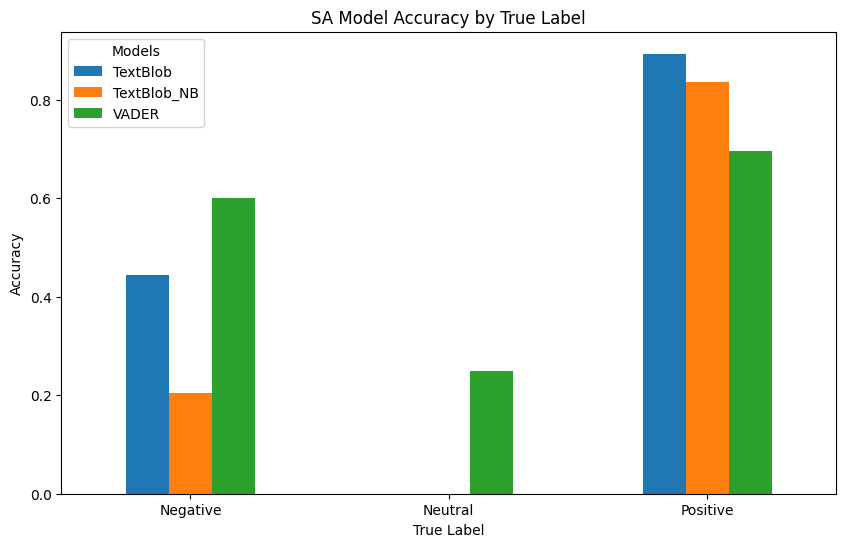

In [66]:
def calculate_accuracy_per_label(df, model_col, true_label_col):
    accuracy_per_label = df.groupby(true_label_col).apply(lambda x: (x[model_col] == x[true_label_col]).mean())
    return accuracy_per_label

textblob_accuracy_per_label = calculate_accuracy_per_label(df_sa, 'Sentiment_Label_TB', 'True_Label')
textblob_nb_accuracy_per_label = calculate_accuracy_per_label(df_sa, 'Sentiment_Label_TB_NB', 'True_Label')
vader_accuracy_per_label = calculate_accuracy_per_label(df_sa, 'Sentiment_Label_VADER', 'True_Label')

accuracy_df = pd.DataFrame({
    'TextBlob': textblob_accuracy_per_label,
    'TextBlob_NB': textblob_nb_accuracy_per_label,
    'VADER': vader_accuracy_per_label
}).reset_index()

print(accuracy_df)


accuracy_df.plot(x='True_Label', kind='bar', figsize=(10, 6))
plt.title('SA Model Accuracy by True Label')
plt.xlabel('True Label')
plt.ylabel('Accuracy')
plt.xticks(rotation=0)
plt.legend(title='Models')
plt.show()
